In [245]:
%matplotlib inline

from helpers import get_session

import numpy as np # is any good data project complete without at least one call to np?
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
sns.set()

In [2]:
def get_df_from_sql():
    engine, Session = get_session()
    df = pd.read_sql_query('select * from ratings', con=engine)
    return df

In [306]:
df = get_df_from_sql()

In [307]:
df.info()
"""Cool, everything is the dtype I want"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 4 columns):
id        1113 non-null int64
device    1113 non-null object
date      1113 non-null datetime64[ns]
rating    1113 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 34.9+ KB


'Cool, everything is the dtype I want'

# Things I want from the df
1. Stacked bar chart for daily ratings of the past week
2. Average rating trendline for the previous month
3. Day's running total of all 3 options
4. Current Score needle
5. Customer Satisfaction per month

## Weekly Stacked Bar Chart

In [308]:
# Barchart for week
df_week = df[df['date'].dt.date > datetime.date(datetime.now()) - timedelta(7)]
week_1 = df_week[df_week['rating'] == 1].groupby(df_week.date.dt.date).count()['id']
week_2 = df_week[df_week['rating'] == 2].groupby(df_week.date.dt.date).count()['id']
week_3 = df_week[df_week['rating'] == 3].groupby(df_week.date.dt.date).count()['id']

In [309]:
df_week = pd.concat([week_1, week_2,week_3], axis=1, sort=True).fillna(0)
df_week.columns = ['1','2','3']

(array([737264., 737265., 737266., 737267., 737268., 737269., 737270.,
        737271., 737272.]), <a list of 9 Text xticklabel objects>)

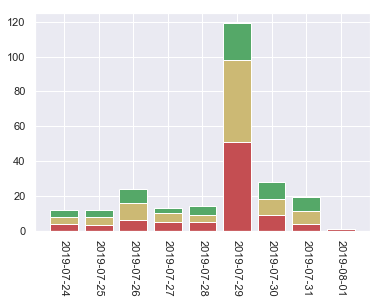

In [310]:
plt.bar(df_week.index, df_week['1'], color='r')
plt.bar(df_week.index, df_week['2'], bottom=df_week['1'], color='y')
plt.bar(df_week.index, df_week['3'], bottom=df_week['1']+df_week['2'], color='g')
plt.xticks(rotation=270)

## Monthly Trend Line

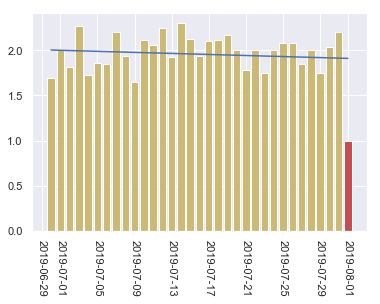

In [295]:
df_month = df[df['date'].dt.date > (datetime.date(datetime.now()) - timedelta(31))]
df_month_avg = df_month.groupby(df_month['date'].dt.date).mean()

ratings = df_month_avg.rating
index = df_month_avg.index
colors = ["r" if rating <1.5 else "y" if rating<2.5 else "g" for rating in ratings]
plt.bar(index, ratings, color= colors)


z = np.polynomial.polynomial.polyfit(range(len(ratings)), ratings, 1)
p = np.poly1d(z[::-1])
z_vals = p(range(len(ratings)))
plt.xticks(rotation=270)
plt.plot(index, z_vals)

## Day's running total for each rating

([<matplotlib.patches.Wedge at 0x13a1a081978>,
 [Text(0.5499999702695115, 0.9526279613277875, '1'),
  Text(-1.0963167924324304, -0.08994159566444968, '2'),
  Text(0.6260500746910869, -0.904467414548078, '3')],
 [Text(0.2999999837833699, 0.5196152516333385, '33.33%\n371'),
  Text(-0.5979909776904165, -0.04905905218060891, '35.94%\n400'),
  Text(0.34148185892241095, -0.4933458624807698, '30.73%\n342')])

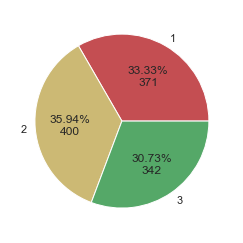

In [330]:
def label(pct, data):
    pct = round(pct,2)
    return "{}%\n{}".format(pct,int(round(pct*data/100)))


df_today = df[df['date'].dt.date == datetime.date(datetime.now())]
df_today = df.groupby('rating').count()
vote_count = df_today['id'].sum()
plt.pie(df_today['id'], labels=df_today.index, colors=['r','y','g'], autopct=lambda pct: label(pct, vote_count))